In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
from datasets import Dataset
import spacy
import core.model_utils as model_utils
import core.constants as constants
import matplotlib.pyplot as plt
import os

In [2]:
# https://github.com/sdadas/polish-nlp-resources#word2vec (needs to be downloaded manually)
word2vec_kv = KeyedVectors.load("./word2vec/word2vec_100_3_polish.bin")

In [3]:
def tokens_to_vector(tokens, max_tokens=50):
    vector_size = word2vec_kv.vector_size
    wv_res = np.zeros((vector_size, max_tokens))
    for index, word in enumerate(tokens):
        if word in word2vec_kv and index < max_tokens:
            wv_res.T[index] = word2vec_kv[word]
    return wv_res.T

In [ ]:
# Needs to be used to download spacy model for Polish
# !python -m spacy download pl_core_news_sm

In [13]:
# spacy_model = spacy.load("pl_core_news_sm")
#
# # Stop words
# stop_words = spacy_model.Defaults.stop_words.copy()
# stop_words.remove("nie")
#
# # Punctuation
# punctuations = string.punctuation
#
#
# # Tokenizer
# def spacy_tokenizer(sentence):
#     doc = spacy_model(sentence)
#
#     # Lemmatizing each token and converting each token into lowercase
#     my_tokens = [ word.lemma_.lower().strip() for word in doc ]
#
#     # Removing stop words and punctuation
#     my_tokens = [ word for word in my_tokens if word not in stop_words and word not in punctuations ]
#     return my_tokens
#
#
# df = pd.read_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl.json')
# df = df.drop(columns=['text'])
# df['tokens'] = df['text_pl'].apply(spacy_tokenizer)
# df['joined_tokens'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))
# df.to_json('./../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens.json')

In [4]:
tokenized_sentences_df = pd.read_json(
    './../data/polish_translated/emotions/equalized_emotions_dataset_pl_with_tokens.json')
tokenized_sentences_df

,emotions,text_pl,tokens,joined_tokens
0,anger,Czuję się całkowicie chciwy,"[czuję, całkowicie, chciwy]",czuję całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami,"[czuję, przytłocić, emocja]",czuję przytłocić emocja
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...,"[nie, czuć, być, efekt, siła, g, oszołomiona, ...",nie czuć być efekt siła g oszołomiona poszedłe...
3,anger,ive just got to tell you all that I feel Racze...,"[ive, just, got, tell, you, all, that, feel, r...",ive just got tell you all that feel raczej nie...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si...","[powiedzieć, być, przepraszać, czuć, sfrustrow...",powiedzieć być przepraszać czuć sfrustrowany z...
...,...,...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj...","[czuć, ostatnio, hojny, pracować, znacznie, zw...",czuć ostatnio hojny pracować znacznie zwykle z...
39996,love,"Czuję, że niektóre postacie nie zasługują na w...","[czuję, niektóry, postać, nie, zasługiwać, wsp...",czuję niektóry postać nie zasługiwać wsparcie ...
39997,fear,"Czuję strach w moich kościach, którego nie moż...","[czuję, strach, kość, nie, móc, wytrząsnąć, wy...",czuję strach kość nie móc wytrząsnąć wymuszć r...
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...,"[czuć, być, kreatywny, czysty, redaktor]",czuć być kreatywny czysty redaktor


In [5]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

tokenized_sentences_df = tokenized_sentences_df.replace({"emotions": ordered_class_labels})

In [6]:
full_dataset = Dataset.from_pandas(tokenized_sentences_df).remove_columns("__index_level_0__")
full_dataset

Dataset({
    features: ['emotions', 'text_pl', 'tokens', 'joined_tokens'],
    num_rows: 40000
})

In [7]:
def tokenize_for_word2vec(sample):
    sample['embeddings'] = [tokens_to_vector(tokens) for tokens in sample['tokens']]
    return sample


full_dataset = full_dataset.map(tokenize_for_word2vec, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [8]:
# Train set: 80%, Validation set: 10%, Test set: 10%
train_dataset, val_dataset, test_dataset = model_utils.split_train_val_test(
    full_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [9]:
columns = ["embeddings"]
label_cols = ["emotions"]
batch_size = 16

tf_train_dataset = model_utils.convert_to_tf_dataset(train_dataset, columns, label_cols, None, batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(val_dataset, columns, label_cols, None, batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(test_dataset, columns, label_cols, None, batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [11]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [12]:
# Model parameters
training_number = 1
model_name = 'emotions_pl_word2vec_external'
training_name = f"training_{training_number}"
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [13]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [14]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=20, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
2000/2000 [==============================] - 16s 7ms/step - loss: 1.6515 - accuracy: 0.2815 - val_loss: 1.5601 - val_accuracy: 0.3397

Epoch 00001: saving model to ./../training_checkpoints\emotions_pl_word2vec_external\training_1\cp-0001.ckpt
Epoch 2/20
2000/2000 [==============================] - 15s 8ms/step - loss: 1.4531 - accuracy: 0.3968 - val_loss: 1.4989 - val_accuracy: 0.3860

Epoch 00002: saving model to ./../training_checkpoints\emotions_pl_word2vec_external\training_1\cp-0002.ckpt
Epoch 3/20
2000/2000 [==============================] - 16s 8ms/step - loss: 1.2871 - accuracy: 0.4769 - val_loss: 1.5293 - val_accuracy: 0.3895

Epoch 00003: saving model to ./../training_checkpoints\emotions_pl_word2vec_external\training_1\cp-0003.ckpt
Epoch 4/20
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1342 - accuracy: 0.5430 - val_loss: 1.6594 - val_accuracy: 0.3920

Epoch 00004: saving model to ./../training_checkpoints\emotions_pl_word2vec_external\trai

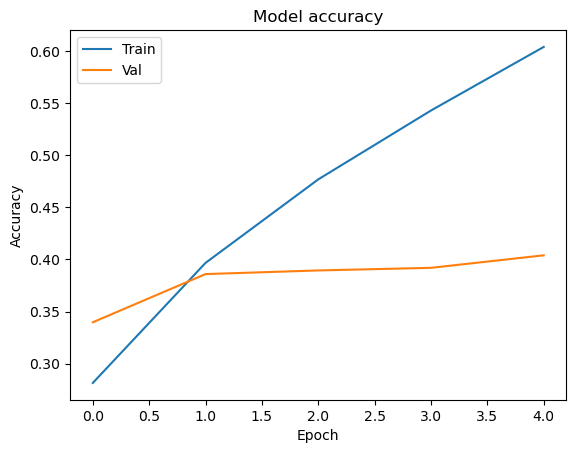

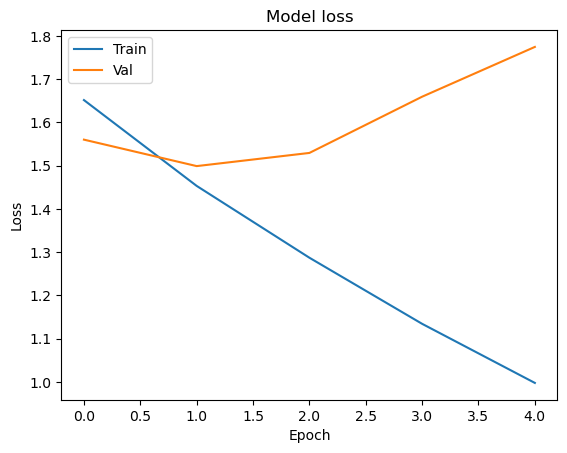

In [15]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [16]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [17]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\emotions_pl_word2vec_external_1\1\assets


In [18]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

250/250 [==============================] - 2s 7ms/step - loss: 1.4836 - accuracy: 0.3930


[1.4835522174835205, 0.3930000066757202]

In [19]:
class_preds = model_utils.get_class_preds(best_model, tf_test_dataset, model_returns_logits=False)

In [20]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['emotions'],
    class_preds=class_preds,
    average='micro'
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.393
Recall score:  0.393
F1 score:  0.393


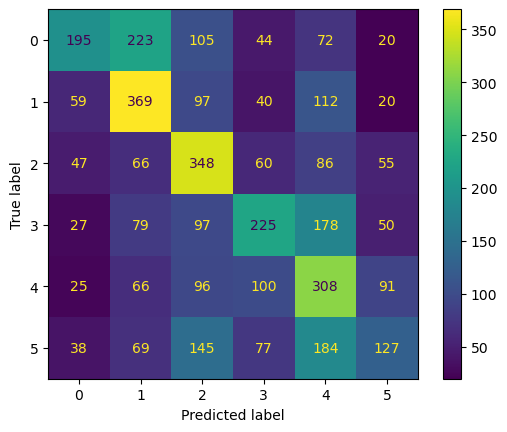

In [21]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['emotions'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [22]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text_pl'],
                                              class_actual=test_dataset['emotions'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 6
            - TEXT: Nie wiem, jak kilka zdań może sprawić, że ludzie, którzy je czytają, natychmiast wiedzą, co naprawdę myślę lub czuję, a nikt nie zadał sobie trudu, aby zapytać mnie w twarz.
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 4
            

            BAD PREDICTION:
            - INDEX: 7
            - TEXT: Po prostu nienawidzę tego, że sprawiło, że czuję się tak paranoicznie i sprawia, że martwię się, że kiedy jest ze swoimi przyjaciółmi beze mnie, a oni mówią, jak bardzo mnie nie lubią i b zdaje sobie sprawę, że może znaleźć kogoś lepszego i bardziej odpowiedniego dla niego
            - PREDICTED VALUE: 2
            - CORRECT VALUE: 5
            

            BAD PREDICTION:
            - INDEX: 9
            - TEXT: Czuję się uprzywilejowany, aby prowadzić
            - PREDICTED VALUE: 4
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 10
           

In [23]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text_pl'], test_dataset['emotions'], class_preds)),
    columns=['text_pl', 'emotions', 'prediction'])
test_df

,text_pl,emotions,prediction
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,4
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2
...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,4
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,4


In [24]:
def map_token_counts(row):
    return len(row['text_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['emotions'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text_pl,emotions,prediction,token_count,count_belonging,correctly_predicted
0,"Myślę, że to prawdopodobnie dobry pomysł, wcią...",5,4,13,12-17,0
1,"Wciąż czuję, że wciąż boję się tego uczucia i ...",5,5,21,18-23,1
2,"Ostatnio czuję się dość nostalgicznie, ale to ...",1,1,16,12-17,1
3,"Jestem pod wrażeniem, że udało mi się wyciągną...",2,2,11,6-11,1
4,"Nie sądzę, że wymieniłem choć jeden uśmiech z ...",2,2,17,12-17,1
...,...,...,...,...,...,...
3995,Czuję się wspaniale zrelaksowany w wyniku,0,0,6,6-11,1
3996,Czuję się zrzędliwy teraz fani futbolu obudzil...,4,4,12,12-17,1
3997,"są związani z tym, co robią, pomimo tego, jak ...",0,4,22,18-23,0
3998,"Czuję i będziesz zaskoczony zmianami, które na...",2,4,9,6-11,0


In [25]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [26]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

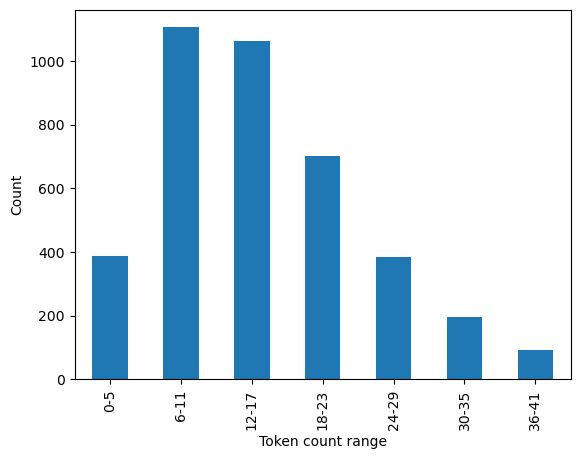

In [27]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [28]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [29]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 201, '6-11': 529, '12-17': 429, '18-23': 223, '24-29': 100, '30-35': 60, '36-41': 17}
Element count:  {'0-5': 386, '6-11': 1106, '12-17': 1064, '18-23': 702, '24-29': 383, '30-35': 197, '36-41': 93}
Accuracies:  {'0-5': 0.5207253886010362, '6-11': 0.4783001808318264, '12-17': 0.4031954887218045, '18-23': 0.3176638176638177, '24-29': 0.26109660574412535, '30-35': 0.30456852791878175, '36-41': 0.1827956989247312}


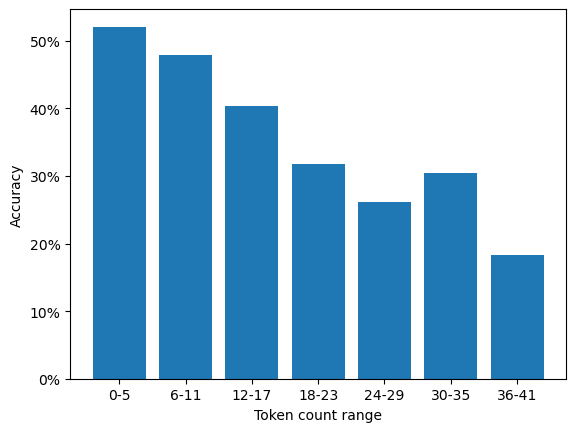

In [30]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()